In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt, rcParams
from matplotlib.colors import LogNorm
from models import Classifier, Metrics, find_threshold, DataSet
from matplotlib.cm import get_cmap
np.random.seed(42)

# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

In [2]:
n_s = int(5e5)
n_b = int(5e5)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,n_s)
u_ = np.random.uniform(0,1,n_b)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T


z_b = np.random.normal(0,1,n_b)
z_s = np.random.normal(0.5,1,n_s)
z_t = np.random.normal(0,1,n_b)

# fig ,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,8),dpi=120)

# _,bins,_ = ax1.hist(m_b,bins=40,density=True,alpha=0.5, label='background')
# ax1.hist(m_s,bins=bins,density=True,alpha=0.5,label='signal')
# ax1.legend()
# ax1.set_xlabel(r"$m$")
# ax1.set_ylabel("Normed Counts")

# ax2.scatter(x_b,y_b,s=5,alpha=0.4)
# ax2.scatter(x_s,y_s,s=5,alpha=0.4)
# ax2.set_xlabel(r"$x$")
# ax2.set_ylabel(r"$y$")

# _,bins,_ = ax3.hist(m_b**2+2.5*m_b,bins=40,density=True,alpha=0.5, label='background')
# ax3.hist(m_s**2+2.5*m_s,bins=bins,density=True,alpha=0.5,label='signal')
# ax3.set_xlabel(r"$m^2 + 2m$")

# _,bins,_ = ax4.hist(z_b,bins=40,density=True,alpha=0.5, label='background')
# ax4.hist(z_s,bins=bins,density=True,alpha=0.5,label='signal')
# ax4.set_xlabel(r"$z$")

# #ax2.set_title("Data")
# fig.tight_layout()
# plt.savefig("./plots/Data.pdf")
# plt.show()

In [3]:
x = np.concatenate([np.stack([m_s,m_s**2+2*m_s,x_s,y_s,z_s],axis=1),
                   np.stack([m_b,m_b**2+2*m_b,x_b,y_b,z_b],axis=1)])

y = np.concatenate([np.zeros(m_s.size),np.ones(m_b.size)])

x_test = np.stack([m_t,m_t**2+2*m_t,x_t,y_t,z_t],axis=1) 
y_test = np.zeros(n_b)
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]


traindataset = DataSet(x_train[::,1:],y_train,x_train[::,0])
valdataset = DataSet(x_val[::,1:],y_val,x_val[::,0])
testTensor= torch.from_numpy(x_test[::,1:]).float()

In [4]:
class WeightedMSE():
    def __init__(self,labels):
        ones = sum(labels)
        self.ones_frac = ones/(labels.shape[0]-ones)
    def __call__(self,pred,target):
        weights = target/self.ones_frac + (1-target)
        return torch.mean(weights*(pred-target)**2)

class FlatLoss():
    def __init__(self,labels,frac,recalculate=True):
        self.frac = frac
        self.mse = WeightedMSE(labels)
        self.recalculate = recalculate
        self.LLoss = None
    def __call__(self,pred,target,x_biased):
        if self.LLoss is None:
            self.LLoss = LegendreLoss(x_biased)
            return self.frac*self.LLoss(pred,target) + (1-self.frac)*self.mse(pred,target)
        if self.recalculate:
            self.LLoss = LegendreLoss(x_biased)
        return self.frac*self.LLoss(pred,target) + (1-self.frac)*self.mse(pred,target)
        

class LegendreLoss():
    def __init__(self,x_biased):
        self.mass, self.ordered_mass = torch.sort(x_biased)
        self.dm = (self.mass.view(-1,32)[:,-1] - self.mass.view(-1,32)[:,0]).view(-1,1)
        self.m = self.mass.view(-1,32).mean(axis=1).view(-1,1)
        self.p0 = 1
        self.p1 = self.m
        self.p2 = (self.m**2-1)/2
        self.scores = 0
        self.legendre = 0
    def __call__(self,pred,target):
        ordered_target = target[self.ordered_mass]
        pred_bins = pred[self.ordered_mass][~(target==2)].view(-1,32)
        ordered_s = pred_bins.argsort(axis=1)
        self.scores = pred_bins
        self.scores = torch.cumsum(self.scores,axis=1)/self.scores.sum(axis=1).view(-1,1)
        a0 = 1/2 * (self.scores*self.dm).sum(axis=0)
        a1 = 3/2 * (self.scores*self.p1*self.dm).sum(axis=0)
        self.legendre = a0 + a1*self.p1
        legendre_loss = ((self.scores - self.legendre)**2).mean()
        return legendre_loss

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('device used in training:', device)

device used in training: cpu


In [6]:
my_cmap = get_cmap('viridis')
my_cmap.set_bad(my_cmap.colors[0])

params = {'epochs'     : 2000,
          'interval'   : 100,
          'batch_size' : 2048,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }

Entering Training...
Epoch:0100/2000 || Train: loss:0.2439, acc:61% || Test: loss: 0.2451, acc:62%, R50: 3.6406, 1/JSD: 407.2466  || 40.5s
Epoch:0200/2000 || Train: loss:0.2355, acc:64% || Test: loss: 0.2375, acc:64%, R50: 4.1350, 1/JSD: 138.0951  || 81.6s
Epoch:0300/2000 || Train: loss:0.2252, acc:67% || Test: loss: 0.2277, acc:66%, R50: 4.6812, 1/JSD: 48.3029  || 128.5s
Epoch:0400/2000 || Train: loss:0.2093, acc:68% || Test: loss: 0.2187, acc:66%, R50: 5.2655, 1/JSD: 23.4854  || 169.8s
Epoch:0500/2000 || Train: loss:0.2064, acc:71% || Test: loss: 0.2118, acc:67%, R50: 5.7923, 1/JSD: 14.6989  || 211.6s
Epoch:0600/2000 || Train: loss:0.2013, acc:70% || Test: loss: 0.2054, acc:69%, R50: 6.4197, 1/JSD: 10.4509  || 253.6s
Epoch:0700/2000 || Train: loss:0.2058, acc:68% || Test: loss: 0.1988, acc:71%, R50: 7.0169, 1/JSD: 7.7712  || 295.5s
Epoch:0800/2000 || Train: loss:0.1912, acc:72% || Test: loss: 0.1918, acc:73%, R50: 7.9465, 1/JSD: 5.4125  || 342.8s
Epoch:0900/2000 || Train: loss:0.1803

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


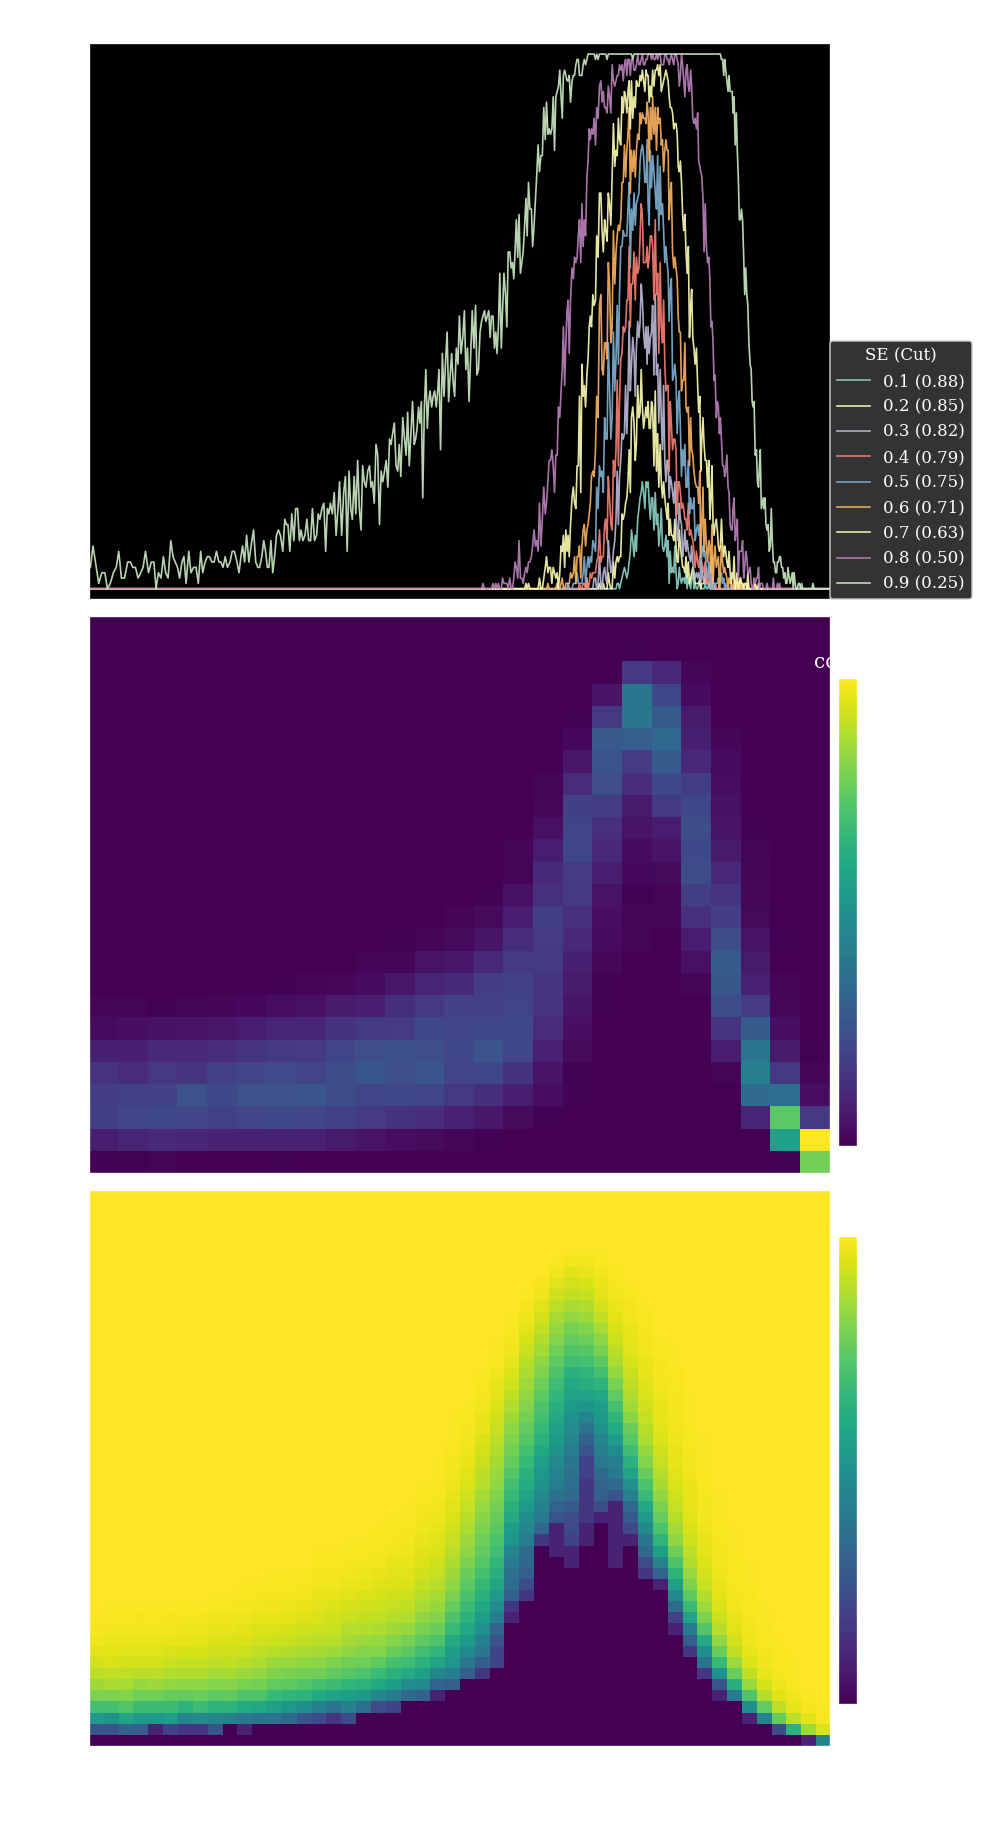

Entering Training...
Epoch:0100/2000 || Train: loss:0.1617, acc:63% || Test: loss: 0.2444, acc:61%, R50: 3.8819, 1/JSD: 96.9267  || 88.9s


KeyboardInterrupt: 

In [7]:
efficiencies = np.linspace(0.1,0.9,9)
for strength in [0,0.5,1,2,3,5,10,15,20]:
    frac = strength/(1+strength)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics(validation=True)
    model_legendre = Classifier(input_size=4)
    model_legendre.loss = FlatLoss(frac=frac,recalculate=False,labels=y_train)
    model_legendre.fit(traindataset=traindataset,
                       valdataset=valdataset,
                       **params,
                       optimizer=torch.optim.SGD(model_L.parameters(),lr=1e-4,momentum=0.)
                       #scheduler=scheduler,
                       metrics=[metrics_train_legendre,metrics_val_legendre])
    
    validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(validation_predictions,(y_val==0),eff))
    
    
    scores = np.array(model_legendre(testTensor).tolist()).reshape(-1,100)
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=50,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
    for j,cut in enumerate(cuts):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_title("(strength: {:.02f}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=17)
    ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

    _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])
    cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
    cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
    cb.ax.set_title("counts")
    ax2.set_ylabel(r"$s$",fontsize=17)

    im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
    ax3.set_ylabel(r"$s$",fontsize=17)

    cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
    cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
    cb.ax.set_title(r"$F(s)$")
    ax3.set_xlabel(r"$m$",fontsize=19)

    fig.tight_layout(pad=0)
    plt.show()

In [ ]:
# validation_predictions = np.array(model_legendre.yhat_val.tolist()).flatten()
# cuts = []
# for eff in efficiencies:
#     cuts.append(find_threshold(validation_predictions,(y_val==1),eff))


# scores = np.array(model_legendre(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
# m = m_t.reshape(-1,100).mean(axis=1)
# F_s = []
# for s in scores.reshape(50,-1):
#     density = np.histogram(s,bins=50,range=(0,1))[0]
#     F_s.append(np.cumsum(density)/density.sum())
# F_s = np.array(F_s).T
# fig, [ax1, ax2, ax3]  = plt.subplots(3,1,figsize=[8,5*3],dpi=120,sharex=True)
# for j,cut in enumerate(cuts):
#     c = f"C{j}" if j!= 6 else f"C11"
#     passed = (scores>cut).sum(axis=1)/scores.shape[1]
#     ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)

# ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
# ax1.set_ylim([-0.02,1.02])
# ax1.set_title("Modified Loss Model (acc: {:.02})".format(metrics_val_legendre.accs[-1]),fontsize=17)
# ax1.legend(loc=(1,0),markerscale=5,title="SE (Cut)",ncol=1)

# _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=25, label="all",cmap='viridis',range=[[-1,1],[0,1]])
# cbaxes = fig.add_axes([0.86, 0.37, 0.02, 0.26]) 
# cb = plt.colorbar(h,ax=ax2,cax = cbaxes)
# cb.ax.set_title("counts")
# ax2.set_ylabel(r"$s$",fontsize=17)

# im = ax3.imshow(F_s,label="all",origin='lower',extent=[-1,1,0,1],aspect="auto",norm=LogNorm(),cmap=my_cmap)
# ax3.set_ylabel(r"$s$",fontsize=17)

# cbaxes = fig.add_axes([0.86, 0.06, 0.02, 0.26]) 
# cb = plt.colorbar(im,ax=ax3,cax = cbaxes)
# cb.ax.set_title(r"$CDF(s)$")
# ax3.set_xlabel(r"$m$",fontsize=19)

# fig.tight_layout(pad=0)
# plt.show()

In [ ]:
for epoch in nepochs:
    for x,y,m in batch:         #x is a feature tensor of shape: (batch size=1024, featrures=10)
                                #y is a vector of labels (1024,) and m is a vector masses (1024,)
        ypred = model(x)
        loss = a*FlatLoss(ypred,y,m) + (1-a) * WeightedMSE(ypred,y) #MSE loss weighted by c_{0,1} for y={0,1}
                                        #c0 = 1 and c1 = numberOfZeros/numberOfOnes in the whole training set
        loss.propagate()

def FlatLoss(predictions,targets,biased_feature):
    m_sorted = sort(biased_feature)           # also normalize between -1 and 1
    m_sorted = m_sorted.reshape(32,32)        # bin the masses into 32 bins (32*32=1024.)
    dm       = max(m,axis=1) - min(m,axis=1)  #find bin width
    m        = mean(m_sorted,axis=1)          # calculate mean mass per bin
    sorted_by_m = argsort(biased_feature)     # used align the scores with masses
    scores =  predictions[sorted_by_m].reshape(32,32)          #bin the scores in bins of mass.
    
    "CDF"  = cumsum(scores,axis=1)/sum(scores,axis=1)# proxy for a cdf calculation
           =(or)   sort(scores,axis=1)               # gives the same results as the above calculation
    c_i    = (2*i+1)/2 sum(dm*P(m)_i*CDF,axis=0)   #Calculate the i th Legendre coefficient 
                                                     #by summing across mass bins for each “percentile” of score
    return sum((CDF - c_0 *P_0 - c_1*P_1)^2)
